### Import libraries

In [1]:
import torch
from torch import nn

from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


### Set device

In [2]:
if torch.cuda.is_available():
    device='gpu'
else:
    device='cpu'
    
device

'gpu'

### Load Data

In [3]:

batch_size=5
num_workers=0
valid_size = 0.2
data_dir="../project_data/xray_abs_chest/Open_I_abd_vs_CXRs"


#define transforms. Data is already normalized between 0 and 1
transform_train=transforms.Compose([    
    transforms.Resize((224,224)),
    transforms.RandomRotation(30),
                                      
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
   
]    
    
    
)
transform_valid=transforms.Compose([                              transforms.Resize((224,224)),
                                
                                transforms.ToTensor(),
                                
                                   ]    
    
    
)



train_data = datasets.ImageFolder(data_dir + '/TRAIN', transform=transform_train)

# obtain training indices that will be used for validation
num_train = len(train_data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print("Total Training Data:{}".format(len(train_idx)))
print("Total Testing Data:{}".format(len(valid_idx)))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)



Total Training Data:60
Total Testing Data:15


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
images.shape

(5, 3, 224, 224)

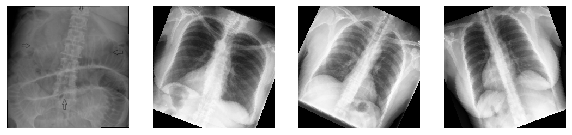

In [5]:
# change this to the trainloader or testloader 
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))



    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax)

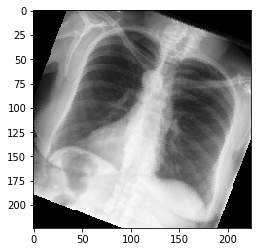

In [6]:
plt.imshow(  images[1].permute(1, 2, 0)  )

In [7]:
#Quick check to see if images are normalized. For the blue channel of an image:
images[1][..., 2].max()

tensor(0.8706)

### Defining the CNN model

In [8]:

class Xray(nn.Module):
    def __init__(self):
        super(Xray,self).__init__()
        #conv1 input:224*224*3
        self.conv1=nn.Conv2d(3,16,3,padding=1)
        #After maxpool,conv2 input:112*112*16
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        #After maxpool,conv3 input:56*56*32
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        #After maxpool, output is 28*28*64
        
        #Max pooling layer
        self.pool=nn.MaxPool2d(2,2) #reduce image size by a factor of 2
        self.fc1=nn.Linear(28*28*64,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,2)
        self.dropout=nn.Dropout(0.20)
        ##self.out_act = nn.Sigmoid()
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #flatten images    
        x= x.view(-1,28*28*64)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)
        #x=self.out_act(x)
        return x
        
# create a complete CNN
model = Xray()
print(model)

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model.cuda() 
        

Xray(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Define loss and optimizer


In [9]:
#criterion=nn.BCEWithLogitsLoss()
#criterion=nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

### Training the model

In [10]:
epochs=20
model.cuda()
valid_loss_min = np.Inf # track change in validation loss
train_losses,valid_losses,accuracy_train,accuracy_valid=[],[],[],[]
for epoch in range(1,epochs+1):
    train_loss=0.0
    valid_loss=0.0
    #correct_train=0.0
    #correct_valid=0.0
    #train model
    model.train()
    
    
    for images,labels in train_loader:

        if torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
            #labels=labels.view(5,-1)
            #labels=labels.float()
             # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            #print(labels)
            #print(output)
            # calculate the batch loss
            loss = criterion(output,labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*images.size(0)
            #correct_train += (output == labels).float().sum()

    #validate model
    model.eval()
    for images,labels in valid_loader:
        if torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
            #labels=labels.view(5,-1)
            #labels=labels.float()
             # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output,labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            valid_loss += loss.item()*images.size(0)
           # correct_valid += (output == labels).float().sum()
            
    # calculate average losses
    train_loss_avg = train_loss/len(train_loader.sampler)
    valid_loss_avg = valid_loss/len(valid_loader.sampler)
    
    train_losses.append(train_loss_avg)
    valid_losses.append(valid_loss_avg)
   # train_losses.append(train_loss/len(train_loader))
    #valid_losses.append(valid_loss/len(valid_loader))
    
    #accuracy_train.append(100 * correct_train / len(train_loader))
    #accuracy_valid.append(100 * correct_valid / len(valid_loader))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss_avg, valid_loss_avg))
    
    # save model if validation loss has decreased
    if valid_loss_avg <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss_avg))
        torch.save(model.state_dict(), 'model_ab_chest.pt')
        valid_loss_min = valid_loss_avg



Epoch: 1 	Training Loss: 0.786959 	Validation Loss: 0.647421
Validation loss decreased (inf --> 0.647421).  Saving model ...
Epoch: 2 	Training Loss: 0.429975 	Validation Loss: 0.052102
Validation loss decreased (0.647421 --> 0.052102).  Saving model ...
Epoch: 3 	Training Loss: 0.081537 	Validation Loss: 0.021792
Validation loss decreased (0.052102 --> 0.021792).  Saving model ...
Epoch: 4 	Training Loss: 0.209558 	Validation Loss: 0.100908
Epoch: 5 	Training Loss: 0.076615 	Validation Loss: 0.007332
Validation loss decreased (0.021792 --> 0.007332).  Saving model ...
Epoch: 6 	Training Loss: 0.183332 	Validation Loss: 0.006019
Validation loss decreased (0.007332 --> 0.006019).  Saving model ...
Epoch: 7 	Training Loss: 0.135609 	Validation Loss: 0.122140
Epoch: 8 	Training Loss: 0.040860 	Validation Loss: 0.002640
Validation loss decreased (0.006019 --> 0.002640).  Saving model ...
Epoch: 9 	Training Loss: 0.179221 	Validation Loss: 0.018355
Epoch: 10 	Training Loss: 0.156549 	Valida

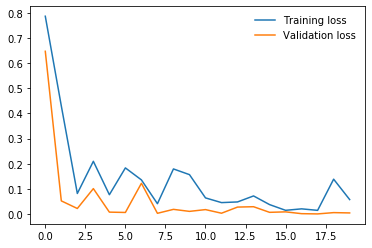

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')

plt.legend(frameon=False)
#ax=plt.gca()
#ax.set_ylim([0,1])

### Load model with lowest validation loss

In [12]:
model.load_state_dict(torch.load('model_ab_chest.pt'))

<All keys matched successfully>

[1 1]


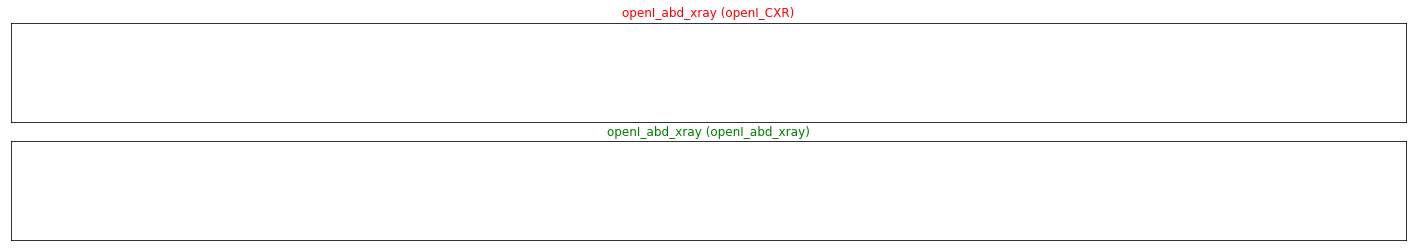

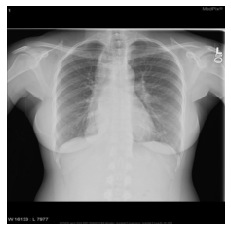

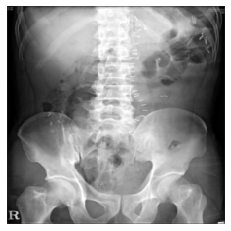

In [13]:
classes=['openI_CXR','openI_abd_xray']
train_on_gpu=False
model.cpu()
test_data = datasets.ImageFolder(data_dir + '/TEST', transform=transform_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=2, num_workers=num_workers)
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
#if train_on_gpu:
    #images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
print(preds)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(2):
    ax = fig.add_subplot(2, 2/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))